# Random Forest

In [1]:
import os, glob, pickle
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Define a function extract_feature to extract the mfcc, chroma, and mel features from a sound file. This function takes 4 parameters- the file name and three Boolean parameters for the three features:

* mfcc: Mel Frequency Cepstral Coefficient, represents the short-term power spectrum of a sound
* chroma: Pertains to the 12 different pitch classes
* mel: Mel Spectrogram Frequency

In [2]:
def extract_feature(file_name, mfcc=True, chroma=True, mel=True):
    # Load the audio file
    X, sample_rate = librosa.load(os.path.join(file_name), res_type="kaiser_fast")
    
    # Compute Short-Time Fourier Transform (STFT) only if chroma is needed
    stft = np.abs(librosa.stft(y=X)) if chroma else None
    
    # Initialize an empty array to store the features
    result = np.array([])

    # Extract MFCC features
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))

    # Extract Chroma features
    if chroma:
        chroma_feat = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
        result = np.hstack((result, chroma_feat))

    # Extract Mel Spectrogram features
    if mel:
        mel_feat = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
        result = np.hstack((result, mel_feat))

    return result



Define a dictionary to hold numbers and the emotions available in the RAVDESS & TESS dataset, and a list to hold all 8 emotions- neutral,calm,happy,sad,angry,fearful,disgust,surprised.

In [3]:
# Emotions in the RAVDESS & TESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
# Emotions to observe
observed_emotions=['neutral','calm','happy','sad','angry','fearful', 'disgust','surprised']

Loading data:

In [6]:
def load_data(test_size=0.2):
    x, y = [], []
    
    for file in glob.glob("C:/Users/ACER/Downloads/CNDMCK/Audio/Ravdess/Actor_*/*.wav"):
        file_name = os.path.basename(file)
        
        emotion = emotions[file_name.split("-")[2]]
        
        if emotion not in observed_emotions:
            continue
        
        feature = extract_feature(file, mfcc=True, chroma=True, mel=True)
        
        x.append(feature)
        y.append(emotion)
    
    return train_test_split(np.array(x), y, test_size=test_size, train_size=0.75, random_state=9)

In [7]:
# Load data
X_train, X_test, y_train, y_test = load_data(test_size=0.2)

# Encoding
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)


Fit/Train the model

In [8]:
# Training data
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train_enc)


RandomForestClassifier(random_state=42)

Accuracy:

In [12]:
y_pred = model.predict(X_test)

# Accuracy
acc = accuracy_score(y_test_enc, y_pred)
print(f"\n🎯 Accuracy: {acc * 100:.2f}%\n")



🎯 Accuracy: 94.63%



In [14]:
# Classification report
print("📊 Classification Report:")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

📊 Classification Report:
              precision    recall  f1-score   support

       angry       0.96      0.95      0.96       130
        calm       0.86      1.00      0.93        38
     disgust       0.99      1.00      0.99        66
     fearful       0.87      0.90      0.89       108
       happy       0.97      0.88      0.92       139
     neutral       0.99      1.00      0.99        99
         sad       0.92      0.93      0.92       107
   surprised       0.99      1.00      0.99        76

    accuracy                           0.95       763
   macro avg       0.94      0.96      0.95       763
weighted avg       0.95      0.95      0.95       763



# Confusion Matrix

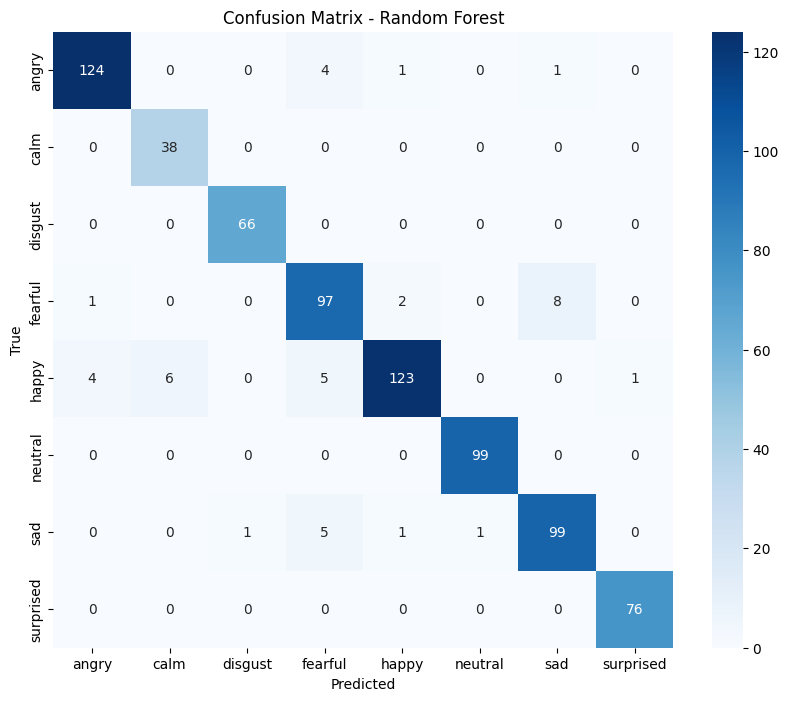

In [29]:
cm = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Saving model

In [26]:
joblib.dump(model, "random_forest_model.joblib")
    
print("Model save as file 'random_forest_model.joblib'")

Model save as file 'random_forest_model.joblib'
